# 🔮 Fluor-RLAT Prediction

Lightweight notebook for predicting fluorescent molecule properties using pretrained models.

**Quick Start:**
1. Go to Runtime → Change runtime type → Select **T4 GPU** (optional, CPU works too)
2. Run all cells
3. Add your molecules to the `molecules` list and run predictions

**Properties predicted:**
- `abs` - Absorption wavelength (nm)
- `em` - Emission wavelength (nm)  
- `plqy` - Photoluminescence quantum yield (0-1)
- `k` - Log molar absorptivity

---

## 1. Install Dependencies

In [1]:
# ============================================================================
# Install Dependencies
# ============================================================================
import os
os.environ['TORCHDYNAMO_DISABLE'] = '1'

# Detect CUDA version
cuda_version = !nvcc --version 2>/dev/null | grep -oP 'release \K[\d.]+'
cuda_ver = cuda_version[0] if cuda_version else "12"
print(f"Detected CUDA: {cuda_ver}")

# Install packages
print("Installing dependencies...")
!pip install rdkit -q

if cuda_ver.startswith('12'):
    !pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html -q
else:
    !pip install dgl -f https://data.dgl.ai/wheels/torch-2.1/cu118/repo.html -q

!pip install dgllife -q

print("✅ Dependencies installed!")
print("⚠️  If first run, restart runtime: Runtime → Restart runtime")

Detected CUDA: 12.8
Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 64.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 5.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 97.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 88.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 M

In [2]:
# ============================================================================
# Import Libraries
# ============================================================================
import os
os.environ['TORCHDYNAMO_DISABLE'] = '1'

import torch
torch._dynamo.config.suppress_errors = True
torch._dynamo.config.disable = True

import numpy as np
import pandas as pd
import dgl
from dgllife.model import AttentiveFPGNN, AttentiveFPReadout
from dgllife.utils import smiles_to_bigraph, AttentiveFPAtomFeaturizer, AttentiveFPBondFeaturizer
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print(f"PyTorch: {torch.__version__}")
print(f"DGL: {dgl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
PyTorch: 2.4.0+cu121
DGL: 2.4.0+cu124
CUDA available: True
Using device: cuda


In [4]:
# ============================================================================
# Mount Google Drive (for checkpoints)
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# ============================================================================
# Clone Repository (for models and data)
# ============================================================================
REPO_URL = "https://github.com/markste-in/fluor_tools.git"
REPO_DIR = "fluor_tools"

if not os.path.exists(REPO_DIR):
    print(f"📥 Cloning repository...")
    !git clone {REPO_URL} -q
    print("✅ Repository cloned!")
else:
    print(f"✅ Repository already exists")

# Paths
MODEL_DIR = f'./{REPO_DIR}/Fluor-RLAT'
DATA_DIR = f'./{REPO_DIR}/Fluor-RLAT/data'
CHECKPOINT_DIR = '/content/drive/MyDrive/fluor_checkpoints'

print(f"📁 Models: {MODEL_DIR}")
print(f"📁 Data: {DATA_DIR}")
print(f"📁 Checkpoints: {CHECKPOINT_DIR}")

📥 Cloning repository...
✅ Repository cloned!
📁 Models: ./fluor_tools/Fluor-RLAT
📁 Data: ./fluor_tools/Fluor-RLAT/data
📁 Checkpoints: /content/drive/MyDrive/fluor_checkpoints


## 2. Model Definitions

In [6]:
# ============================================================================
# Model Architectures
# ============================================================================

# Use AttentiveFP featurizers - they store features under 'hv' and 'he' keys
ATOM_FEATURIZER = AttentiveFPAtomFeaturizer(atom_data_field='hv')
BOND_FEATURIZER = AttentiveFPBondFeaturizer(bond_data_field='he')
GRAPH_FEAT_SIZE = 256

# Model configs (must match pretrained models)
MODEL_CONFIGS = {
    'abs':  {'num_layers': 2, 'num_timesteps': 2, 'dropout': 0.3, 'model_class': 'GraphFingerprintsModel'},
    'em':   {'num_layers': 3, 'num_timesteps': 1, 'dropout': 0.3, 'model_class': 'GraphFingerprintsModel'},
    'plqy': {'num_layers': 2, 'num_timesteps': 3, 'dropout': 0.4, 'model_class': 'GraphFingerprintsModelFC'},
    'k':    {'num_layers': 3, 'num_timesteps': 1, 'dropout': 0.3, 'model_class': 'GraphFingerprintsModelFC'},
}


class FingerprintAttentionCNN(nn.Module):
    """CNN with attention for fingerprint processing (used by abs/em models)."""
    def __init__(self, input_dim, conv_channels=256):
        super().__init__()
        self.conv_feat = nn.Conv1d(1, conv_channels, kernel_size=3, padding=1)
        self.conv_attn = nn.Conv1d(1, conv_channels, kernel_size=3, padding=1)
        self.softmax = nn.Softmax(dim=-1)
        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):
        x = x.unsqueeze(1)
        feat_map = self.conv_feat(x)
        attn_map = self.conv_attn(x)
        attn_weights = self.softmax(attn_map)
        attn_out = torch.sum(feat_map * attn_weights, dim=-1)
        pooled = self.pool(feat_map).squeeze(-1)
        return torch.cat([attn_out, pooled], dim=1)


class GraphFingerprintsModel(nn.Module):
    """Model for abs/em: AttentiveFP GNN + CNN attention for fingerprints."""
    def __init__(self, node_feat_size, edge_feat_size, solvent_dim, smiles_extra_dim,
                 graph_feat_size=256, num_layers=2, num_timesteps=2, n_tasks=1, dropout=0.3):
        super().__init__()
        self.solvent_dim = solvent_dim
        
        self.gnn = AttentiveFPGNN(node_feat_size=node_feat_size, edge_feat_size=edge_feat_size,
                                   num_layers=num_layers, graph_feat_size=graph_feat_size, dropout=dropout)
        self.readout = AttentiveFPReadout(feat_size=graph_feat_size, num_timesteps=num_timesteps, dropout=dropout)
        self.fp_extractor = FingerprintAttentionCNN(smiles_extra_dim, conv_channels=graph_feat_size)
        self.solvent_extractor = nn.Sequential(
            nn.Linear(solvent_dim, 256), nn.ReLU(), nn.Dropout(dropout), nn.Linear(256, graph_feat_size))
        self.predict = nn.Sequential(
            nn.Dropout(dropout), nn.Linear(graph_feat_size * 4, 128), nn.ReLU(), nn.Linear(128, n_tasks))
        
    def forward(self, graph, node_feats, edge_feats, fingerprints):
        node_out = self.gnn(graph, node_feats, edge_feats)
        graph_out = self.readout(graph, node_out, False)
        solvent_out = self.solvent_extractor(fingerprints[:, :self.solvent_dim])
        smiles_extra_out = self.fp_extractor(fingerprints[:, self.solvent_dim:])
        combined = torch.cat([graph_out, solvent_out, smiles_extra_out], dim=1)
        return self.predict(combined)


class GraphFingerprintsModelFC(nn.Module):
    """Model for plqy/k: AttentiveFP GNN + Simple FC for fingerprints."""
    def __init__(self, node_feat_size, edge_feat_size, fp_size,
                 graph_feat_size=256, num_layers=2, num_timesteps=2, n_tasks=1, dropout=0.3):
        super().__init__()
        
        self.gnn = AttentiveFPGNN(node_feat_size=node_feat_size, edge_feat_size=edge_feat_size,
                                   num_layers=num_layers, graph_feat_size=graph_feat_size, dropout=dropout)
        self.readout = AttentiveFPReadout(feat_size=graph_feat_size, num_timesteps=num_timesteps, dropout=dropout)
        self.fp_fc = nn.Sequential(
            nn.Linear(fp_size, 256), nn.ReLU(), nn.Dropout(dropout), nn.Linear(256, graph_feat_size))
        self.predict = nn.Sequential(
            nn.Dropout(dropout), nn.Linear(graph_feat_size * 2, 128), nn.ReLU(), nn.Linear(128, n_tasks))
        
    def forward(self, graph, node_feats, edge_feats, fingerprints):
        node_out = self.gnn(graph, node_feats, edge_feats)
        graph_out = self.readout(graph, node_out, False)
        fp_out = self.fp_fc(fingerprints)
        combined = torch.cat([graph_out, fp_out], dim=1)
        return self.predict(combined)


def smiles_to_graph(smiles):
    """Convert SMILES to DGL graph."""
    try:
        return smiles_to_bigraph(smiles, node_featurizer=ATOM_FEATURIZER, 
                                  edge_featurizer=BOND_FEATURIZER, add_self_loop=False)
    except:
        return None

print("✅ Model classes defined")

✅ Model classes defined


## 3. Prediction Function

In [7]:
# ============================================================================
# Prediction Function
# ============================================================================

def predict_properties(molecule_smiles, solvent_smiles, model_dir=MODEL_DIR, 
                       data_dir=DATA_DIR, checkpoint_dir=CHECKPOINT_DIR, device='cuda'):
    """Predict all properties for a single molecule."""
    
    # Generate molecular graph
    graph = smiles_to_graph(molecule_smiles)
    if graph is None:
        raise ValueError(f"Could not parse molecule SMILES: {molecule_smiles}")
    
    mol = Chem.MolFromSmiles(molecule_smiles)
    sol = Chem.MolFromSmiles(solvent_smiles)
    if mol is None or sol is None:
        raise ValueError("Invalid SMILES")
    
    # Generate Morgan fingerprints (1024-bit, radius 2)
    mol_fp = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024), dtype=np.float32)
    sol_fp = np.array(AllChem.GetMorganFingerprintAsBitVect(sol, radius=2, nBits=1024), dtype=np.float32)
    
    # Compute molecular descriptors
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    double_bonds = sum(1 for bond in mol.GetBonds() 
                       if bond.GetBondType() == Chem.BondType.DOUBLE or bond.GetIsAromatic())
    ring_count = mol.GetRingInfo().NumRings()
    
    # Solvent mapping (simplified)
    solvent_mapping = {'CC1=CC=CC=C1': 6, 'Cc1ccccc1': 6, 'CCO': 2, 'CO': 1, 'c1ccccc1': 5}
    solvent_num = solvent_mapping.get(solvent_smiles, 0)
    
    # Detect scaffold (BODIPY check)
    bodipy_pattern = Chem.MolFromSmarts('[#5](-F)(-F)(-[#7])(-[#7])')
    tag = 5 if bodipy_pattern and mol.HasSubstructMatch(bodipy_pattern) else 0
    
    # Create scaffold flags
    scaffold_flags = np.zeros(136, dtype=np.float32)
    if tag == 5:
        scaffold_flags[3] = 1
    
    unimol_plus = 3.49
    numeric_feats = np.array([solvent_num, tag, mw, logp, tpsa, double_bonds, ring_count, unimol_plus], dtype=np.float32)
    
    predictions = {}
    n_feats = graph.ndata['hv'].shape[1]
    e_feats = graph.edata['he'].shape[1]
    
    for target in ['abs', 'em', 'plqy', 'k']:
        model_path = os.path.join(model_dir, f'Model_{target}.pth')
        if not os.path.exists(model_path):
            continue
        
        # Load training data to fit scalers
        train_path = os.path.join(data_dir, f'train_{target}.csv')
        if not os.path.exists(train_path):
            continue
            
        train_df = pd.read_csv(train_path)
        
        # Fit scalers
        label_scaler = StandardScaler()
        label_scaler.fit(train_df[[target]].values)
        
        num_scaler = MinMaxScaler()
        num_scaler.fit(train_df.iloc[:, 8:16].values)
        numeric_scaled = num_scaler.transform(numeric_feats.reshape(1, -1)).flatten()
        
        # Combine features
        extra_feats = np.concatenate([numeric_scaled, scaffold_flags]).astype(np.float32)
        fp = np.concatenate([sol_fp, mol_fp, extra_feats])
        
        config = MODEL_CONFIGS[target]
        
        if config['model_class'] == 'GraphFingerprintsModel':
            model = GraphFingerprintsModel(
                node_feat_size=n_feats, edge_feat_size=e_feats,
                solvent_dim=1024, smiles_extra_dim=len(fp)-1024,
                graph_feat_size=GRAPH_FEAT_SIZE, num_layers=config['num_layers'],
                num_timesteps=config['num_timesteps'], dropout=config['dropout'])
        else:
            model = GraphFingerprintsModelFC(
                node_feat_size=n_feats, edge_feat_size=e_feats, fp_size=len(fp),
                graph_feat_size=GRAPH_FEAT_SIZE, num_layers=config['num_layers'],
                num_timesteps=config['num_timesteps'], dropout=config['dropout'])
        
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        model = model.to(device)
        model.eval()
        
        graph_batch = dgl.batch([graph]).to(device)
        fp_tensor = torch.tensor(fp, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            pred = model(graph_batch, graph_batch.ndata['hv'], graph_batch.edata['he'], fp_tensor)
            pred_scaled = pred.item()
        
        predictions[target] = label_scaler.inverse_transform([[pred_scaled]])[0, 0]
    
    return predictions

print("✅ Prediction function defined")

✅ Prediction function defined


## 4. Define Molecules to Predict

In [14]:
# ============================================================================
# 🧪 LOAD MOLECULES FROM CSV
# ============================================================================

# Load from Daten_clean.csv in Google Drive models directory
CSV_PATH = '/content/drive/MyDrive/fluor_models/Daten_clean.csv'

# Solvent SMILES mapping (German solvent names to SMILES)
SOLVENT_SMILES = {
    'Toluol': 'CC1=CC=CC=C1',
    'toluol': 'CC1=CC=CC=C1',
    'Toluene': 'CC1=CC=CC=C1',
    'toluene': 'CC1=CC=CC=C1',
    'EtOH': 'CCO',
    'Ethanol': 'CCO',
    'MeOH': 'CO',
    'Methanol': 'CO',
    'DCM': 'ClCCl',
    'CH2Cl2': 'ClCCl',
    'Dichlormethan': 'ClCCl',
    'CHCl3': 'ClC(Cl)Cl',
    'Chloroform': 'ClC(Cl)Cl',
    'Benzol': 'c1ccccc1',
    'Benzene': 'c1ccccc1',
    'DMSO': 'CS(=O)C',
    'Wasser': 'O',
    'Water': 'O',
    'Aceton': 'CC(=O)C',
    'Acetone': 'CC(=O)C',
    'THF': 'C1CCOC1',
    'Cyclohexan': 'C1CCCCC1',
    'Cyclohexane': 'C1CCCCC1',
    'Hexan': 'CCCCCC',
    'Hexane': 'CCCCCC',
}

if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    print(f"📂 Loaded {len(df)} molecules from {CSV_PATH}")
    
    # Filter rows with valid SMILES and solvent
    df = df.dropna(subset=['smiles', 'solvent'])
    print(f"   {len(df)} molecules have both SMILES and solvent")
    
    # Convert solvent names to SMILES
    molecules = []
    skipped = []
    for _, row in df.iterrows():
        solvent_name = str(row['solvent']).strip()
        solvent_smiles = SOLVENT_SMILES.get(solvent_name)
        
        if solvent_smiles:
            molecules.append((row['name'], row['smiles'], solvent_smiles, solvent_name))
        else:
            skipped.append((row['name'], solvent_name))
    
    print(f"   {len(molecules)} molecules with known solvent SMILES")
    if skipped:
        print(f"   ⚠️ Skipped {len(skipped)} with unknown solvent: {set(s[1] for s in skipped)}")
else:
    print(f"⚠️ CSV not found: {CSV_PATH}")
    print("   Using default molecules instead...")
    
    # Default molecules (fallback)
    molecules = [
        ("BODIPY-phenyl", "C2=C1C7=C(C(=[N+]1[B-]([N]3C2=C5C(=C3C4=CC=CC=C4)C=CC=C5)(F)F)C6=CC=CC=C6)C=CC=C7", "CC1=CC=CC=C1", "Toluol"),
    ]

print(f"\n🧪 Molecules to predict: {len(molecules)}")
print(f"\nFirst 10:")
for name, smiles, sol_smiles, sol_name in molecules[:10]:
    print(f"   • {name} in {sol_name}")

📂 Loaded 126 molecules from /content/drive/MyDrive/fluor_models/Daten_clean.csv
   119 molecules have both SMILES and solvent
   115 molecules with known solvent SMILES
   ⚠️ Skipped 4 with unknown solvent: {'10mM Tris pH8'}

🧪 Molecules to predict: 115

First 10:
   • BBOT in Toluol
   • Coumarin 102 in Toluol
   • Coumarin 6 in Toluol
   • FR-NH2 in Methanol
   • Macrolex Gelb in Toluol
   • Macrolex Rot in Toluol
   • Macrolex Rot in Chloroform
   • Nilrot in Toluol
   • Rh-6G in MeOH
   • Rh-101 in MeOH


## 5. Run Predictions

In [15]:
# ============================================================================
# Run Predictions for All Molecules
# ============================================================================

print(f"🔮 Running predictions for {len(molecules)} molecules...\n")
all_results = []

for i, (name, smiles, solvent_smiles, solvent_name) in enumerate(molecules):
    try:
        preds = predict_properties(smiles, solvent_smiles, model_dir=MODEL_DIR, 
                                   data_dir=DATA_DIR, device=device)
        preds['name'] = name
        preds['smiles'] = smiles
        preds['solvent'] = solvent_name
        all_results.append(preds)
        
        # Progress indicator
        if (i + 1) % 10 == 0 or i == 0:
            print(f"   ✅ Processed {i+1}/{len(molecules)} molecules")
    except Exception as e:
        print(f"   ❌ {name}: {e}")

print(f"\n✅ Successfully predicted {len(all_results)}/{len(molecules)} molecules")

# Display results
print("\n" + "="*80)
print("📊 PREDICTION RESULTS")
print("="*80)

# Show first 10 detailed results
for preds in all_results[:10]:
    print(f"\n🧪 {preds['name']} ({preds['solvent']})")
    print(f"   SMILES: {preds['smiles'][:50]}{'...' if len(preds['smiles']) > 50 else ''}")
    print(f"   Absorption (abs):     {preds.get('abs', float('nan')):>7.1f} nm")
    print(f"   Emission (em):        {preds.get('em', float('nan')):>7.1f} nm")
    print(f"   Quantum Yield (plqy): {preds.get('plqy', float('nan')):>7.3f}")
    print(f"   Log ε (k):            {preds.get('k', float('nan')):>7.2f}")

if len(all_results) > 10:
    print(f"\n... and {len(all_results) - 10} more molecules")

print("\n" + "="*80)

# Summary table
if all_results:
    results_df = pd.DataFrame(all_results)[['name', 'solvent', 'abs', 'em', 'plqy', 'k', 'smiles']]
    results_df.columns = ['Molecule', 'Solvent', 'Abs (nm)', 'Em (nm)', 'PLQY', 'Log ε', 'SMILES']
    print("\n📋 Summary Table:")
    display(results_df)
    
    # Save to CSV
    output_path = './predictions_output.csv'
    results_df.to_csv(output_path, index=False)
    print(f"\n💾 Results saved to {output_path}")

🔮 Running predictions for 115 molecules...

   ✅ Processed 1/115 molecules
   ✅ Processed 10/115 molecules
   ✅ Processed 20/115 molecules
   ✅ Processed 30/115 molecules
   ✅ Processed 40/115 molecules
Invalid mol found
   ❌ BJ3185: Could not parse molecule SMILES: CC(C)(C)c1cc(cc2OB(F)(F)N(=Cc21)/C=C/N1=Cc2c(OB1(F)F)cc(cc2C(C)(C)C)C(C)(C)C)C(C)(C)C
   ✅ Processed 50/115 molecules
   ✅ Processed 60/115 molecules
   ✅ Processed 70/115 molecules
   ✅ Processed 80/115 molecules
   ✅ Processed 90/115 molecules
   ✅ Processed 100/115 molecules
   ✅ Processed 110/115 molecules

✅ Successfully predicted 114/115 molecules

📊 PREDICTION RESULTS

🧪 BBOT (Toluol)
   SMILES: CC(C)(C)c1ccc2oc(nc2c1)c1sc(cc1)c1oc2ccc(cc2n1)C(C...
   Absorption (abs):       377.0 nm
   Emission (em):          428.5 nm
   Quantum Yield (plqy):   0.944
   Log ε (k):               4.68

🧪 Coumarin 102 (Toluol)
   SMILES: O=C1C=C(C)c2cc3CCCN4CCCc(c2O1)c43
   Absorption (abs):       382.3 nm
   Emission (em):          42

,Molecule,Solvent,Abs (nm),Em (nm),PLQY,Log ε,SMILES
0,BBOT,Toluol,376.987715,428.494148,0.944382,4.683788,CC(C)(C)c1ccc2oc(nc2c1)c1sc(cc1)c1oc2ccc(cc2n1...
1,Coumarin 102,Toluol,382.280336,422.347037,0.724138,4.371048,O=C1C=C(C)c2cc3CCCN4CCCc(c2O1)c43
2,Coumarin 6,Toluol,437.665103,472.394301,0.621515,4.522059,O=C1Oc2cc(ccc2C=C1c1sc2ccccc2n1)N(CC)CC
3,FR-NH2,Methanol,513.141048,542.096656,0.176657,4.513532,O=C(N1CCC(CC1)CN)c1ccccc1C1=C2C=C\C(=N/CC(F)(F...
4,Macrolex Gelb,Toluol,448.733638,457.259110,0.785826,4.828258,O=C1Oc2cc(ccc2C=C1c1oc2ccc(Cl)cc2n1)N(CC)CC
...,...,...,...,...,...,...,...
109,BJ5179,Toluol,514.407591,514.248819,0.848753,4.770383,Cc1cc(C)c2n1[B-](OC(=O)C(F)(F)F)(OC(=O)C(F)(F)...
110,BJ5161,Toluol,527.308844,543.201930,0.881110,4.751227,CC1=[N+]2C(=C(c3n(c(C)c(Cl)c3C)[B-]2(F)F)c2ccc...
111,BJ6051,Toluol,613.008997,669.972047,0.353163,4.755244,Cc1cc(C)cc(C)c1C1=CC(=[N+]2C1=Nc1n(c(cc1c1c(C)...
112,BJ6070,Toluol,637.627266,656.546115,0.742101,5.000829,F[B-]1(F)[N+]2=C(c3ccccc3C2=Cc2n1c(c1ccccc21)c...



💾 Results saved to ./predictions_output.csv


## 5b. Compare Predictions with Actual Experimental Data

Compare predictions from **pretrained** and **retrained** models against actual experimental values.

📊 COMPARISON: Pretrained vs Retrained vs Actual
✅ Custom models found in /content/drive/MyDrive/fluor_models

🔮 Running predictions with both model sets...


Predicting:   0%|          | 0/115 [00:00<?, ?it/s]

Invalid mol found
   ❌ BJ3185: Could not parse molecule SMILES: CC(C)(C)c1cc(cc2OB(F)(F)N(=Cc21)/C=C/N1=Cc2c(OB1(F)F)cc(cc2C(C)(C)C)C(C)(C)C)C(C)(C)C

📋 Full Comparison Table


,Molecule,Pre_Abs,Retrained_Abs,Actual_Abs,Pre_Em,Retrained_Em,Actual_Em,Pre_PLQY,Retrained_PLQY,Actual_PLQY
0,BBOT,376.99,374.08,376.0,428.49,431.18,434.0,0.94,0.92,1.00
1,Coumarin 102,382.28,381.33,373.0,422.35,404.71,420.0,0.72,0.66,0.77
2,Coumarin 6,437.67,441.04,439.0,472.39,467.35,487.0,0.62,0.58,0.72
3,FR-NH2,513.14,490.99,512.0,542.10,541.86,533.0,0.18,0.03,NaN
4,FR-NH2,513.14,490.99,509.0,542.10,541.86,532.0,0.18,0.03,NaN
...,...,...,...,...,...,...,...,...,...,...
112,BJ5179,514.41,505.35,509.0,514.25,520.57,521.0,0.85,0.49,NaN
113,BJ5161,527.31,530.07,531.0,543.20,541.20,545.0,0.88,0.79,NaN
114,BJ6051,613.01,621.32,637.0,669.97,675.33,661.0,0.35,0.24,NaN
115,BJ6070,637.63,637.65,645.0,656.55,662.42,668.0,0.74,0.86,NaN



📈 ERROR ANALYSIS: Pretrained vs Retrained

Absorption (nm):
  Pretrained:  MAE=22.42nm, RMSE=39.77nm, R²=0.880 (n=117)
  Retrained:   MAE=25.33nm, RMSE=41.66nm, R²=0.869 (n=117)
  Improvement: MAE ❌ -2.91nm, R² ❌ -0.012

Emission (nm):
  Pretrained:  MAE=25.08nm, RMSE=33.00nm, R²=0.884 (n=115)
  Retrained:   MAE=23.59nm, RMSE=30.32nm, R²=0.902 (n=115)
  Improvement: MAE ✅ +1.49nm, R² ✅ +0.018

PLQY:
  Pretrained:  MAE=0.21, RMSE=0.31, R²=-2.154 (n=10)
  Retrained:   MAE=0.28, RMSE=0.39, R²=-4.068 (n=10)
  Improvement: MAE ❌ -0.08, R² ❌ -1.914

log(ε):
  Pretrained:  MAE=0.16, RMSE=0.21, R²=0.505 (n=74)
  Retrained:   MAE=0.20, RMSE=0.26, R²=0.221 (n=74)
  Improvement: MAE ❌ -0.04, R² ❌ -0.284

📊 SCATTER PLOTS


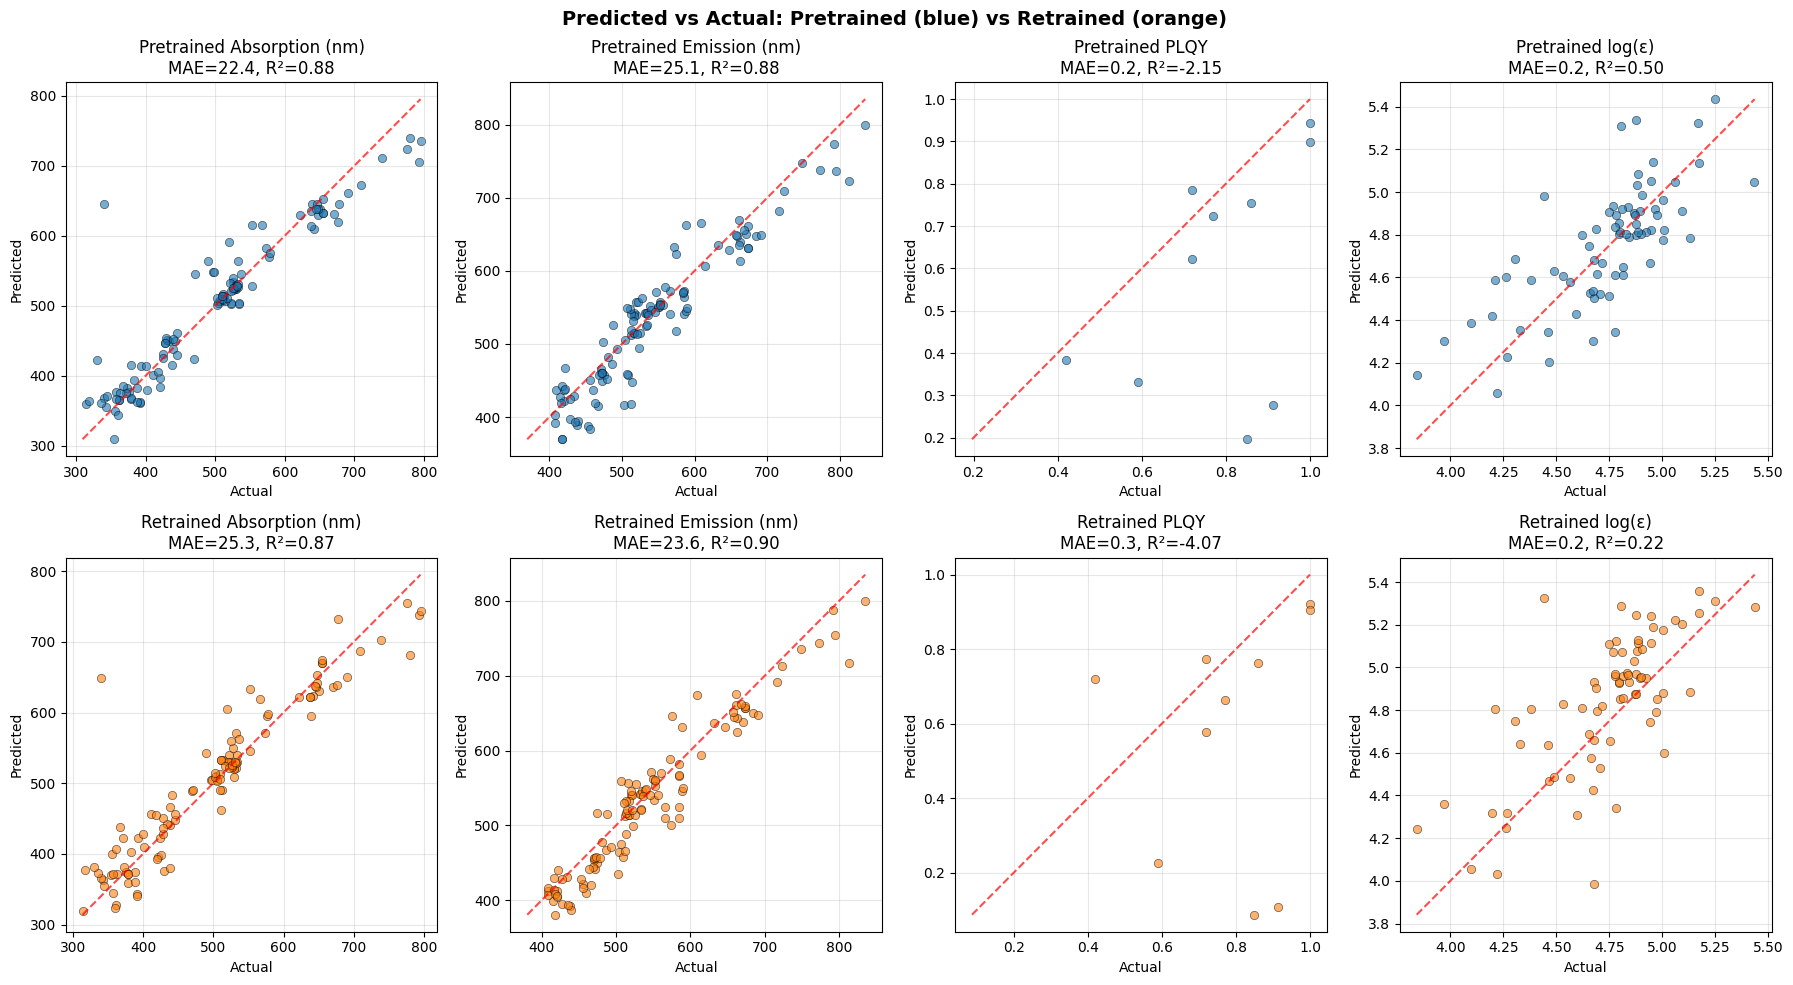


📊 METRICS SUMMARY TABLE


,Property,Pre_MAE,Pre_RMSE,Pre_R²,Ret_MAE,Ret_RMSE,Ret_R²
0,Absorption (nm),22.423,39.770,0.880,25.330,41.655,0.869
1,Emission (nm),25.078,33.004,0.884,23.586,30.320,0.902
2,PLQY,0.206,0.307,-2.154,0.281,0.389,-4.068
3,log(ε),0.162,0.206,0.505,0.201,0.259,0.221



💾 Full comparison saved to full_comparison.csv
💾 Plot saved to prediction_comparison.png


In [16]:
# ============================================================================
# Compare Pretrained vs Retrained Models vs Actual Experimental Data
# ============================================================================
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Paths
CUSTOM_MODEL_DIR = '/content/drive/MyDrive/fluor_models'
USE_CUSTOM_MODELS = os.path.exists(CUSTOM_MODEL_DIR) and any(
    os.path.exists(os.path.join(CUSTOM_MODEL_DIR, f'Model_{t}.pth')) for t in ['abs', 'em', 'plqy', 'k']
)

print("=" * 70)
print("📊 COMPARISON: Pretrained vs Retrained vs Actual")
print("=" * 70)

if USE_CUSTOM_MODELS:
    print(f"✅ Custom models found in {CUSTOM_MODEL_DIR}")
else:
    print(f"⚠️ No custom models found - using pretrained only")

# Run predictions with BOTH model sets
print("\n🔮 Running predictions with both model sets...")

all_comparison = []
for i, (name, smiles, solvent_smiles, solvent_name) in enumerate(tqdm(molecules, desc="Predicting")):
    try:
        # Pretrained models
        preds_pre = predict_properties(smiles, solvent_smiles, model_dir=MODEL_DIR, 
                                        data_dir=DATA_DIR, device=device)
        
        row = {
            'Molecule': name,
            'Solvent': solvent_name,
            'SMILES': smiles,
            'Pre_Abs': preds_pre.get('abs', float('nan')),
            'Pre_Em': preds_pre.get('em', float('nan')),
            'Pre_PLQY': preds_pre.get('plqy', float('nan')),
            'Pre_LogEps': preds_pre.get('k', float('nan')),
        }
        
        # Custom/Retrained models (if available)
        if USE_CUSTOM_MODELS:
            preds_custom = predict_properties(smiles, solvent_smiles, model_dir=CUSTOM_MODEL_DIR, 
                                              data_dir=DATA_DIR, device=device)
            row['Retrained_Abs'] = preds_custom.get('abs', float('nan'))
            row['Retrained_Em'] = preds_custom.get('em', float('nan'))
            row['Retrained_PLQY'] = preds_custom.get('plqy', float('nan'))
            row['Retrained_LogEps'] = preds_custom.get('k', float('nan'))
        
        all_comparison.append(row)
    except Exception as e:
        print(f"   ❌ {name}: {e}")

comparison_df = pd.DataFrame(all_comparison)

# Load actual experimental values and merge
csv_df = pd.read_csv(CSV_PATH)
comparison_df = comparison_df.merge(
    csv_df[['name', 'abs', 'em', 'plqy', 'epsilon']], 
    left_on='Molecule', right_on='name', how='left'
)
comparison_df = comparison_df.rename(columns={
    'abs': 'Actual_Abs', 'em': 'Actual_Em', 
    'plqy': 'Actual_PLQY', 'epsilon': 'Actual_Epsilon'
})
comparison_df['Actual_LogEps'] = np.log10(comparison_df['Actual_Epsilon'].replace(0, np.nan))

# Display comparison table
print("\n" + "=" * 70)
print("📋 Full Comparison Table")
print("=" * 70)

if USE_CUSTOM_MODELS:
    display_cols = ['Molecule', 'Pre_Abs', 'Retrained_Abs', 'Actual_Abs', 
                    'Pre_Em', 'Retrained_Em', 'Actual_Em',
                    'Pre_PLQY', 'Retrained_PLQY', 'Actual_PLQY']
else:
    display_cols = ['Molecule', 'Pre_Abs', 'Actual_Abs', 'Pre_Em', 'Actual_Em',
                    'Pre_PLQY', 'Actual_PLQY', 'Pre_LogEps', 'Actual_LogEps']

display(comparison_df[display_cols].round(2))

# ============================================================================
# Error Analysis Function
# ============================================================================
def calc_metrics(pred, actual, name):
    """Calculate MAE, RMSE, and R² for a property"""
    mask = actual.notna() & pred.notna()
    if mask.sum() < 2:
        return None
    p, a = pred[mask], actual[mask]
    mae = np.abs(p - a).mean()
    rmse = np.sqrt(((p - a) ** 2).mean())
    ss_res = ((a - p) ** 2).sum()
    ss_tot = ((a - a.mean()) ** 2).sum()
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else float('nan')
    return {'N': int(mask.sum()), 'MAE': mae, 'RMSE': rmse, 'R²': r2}

# ============================================================================
# Calculate Metrics for Both Models
# ============================================================================
print("\n" + "=" * 70)
print("📈 ERROR ANALYSIS: Pretrained vs Retrained")
print("=" * 70)

properties = [
    ('Abs', 'Absorption (nm)', 'nm'),
    ('Em', 'Emission (nm)', 'nm'),
    ('PLQY', 'PLQY', ''),
    ('LogEps', 'log(ε)', '')
]

metrics_summary = []
for prop, prop_name, unit in properties:
    pre_col = f'Pre_{prop}'
    actual_col = f'Actual_{prop}'
    
    m_pre = calc_metrics(comparison_df[pre_col], comparison_df[actual_col], prop_name)
    
    if m_pre:
        print(f"\n{prop_name}:")
        print(f"  Pretrained:  MAE={m_pre['MAE']:.2f}{unit}, RMSE={m_pre['RMSE']:.2f}{unit}, R²={m_pre['R²']:.3f} (n={m_pre['N']})")
        
        row = {'Property': prop_name, 'Pre_MAE': m_pre['MAE'], 'Pre_RMSE': m_pre['RMSE'], 'Pre_R²': m_pre['R²']}
        
        if USE_CUSTOM_MODELS:
            retrained_col = f'Retrained_{prop}'
            m_ret = calc_metrics(comparison_df[retrained_col], comparison_df[actual_col], prop_name)
            if m_ret:
                print(f"  Retrained:   MAE={m_ret['MAE']:.2f}{unit}, RMSE={m_ret['RMSE']:.2f}{unit}, R²={m_ret['R²']:.3f} (n={m_ret['N']})")
                
                # Improvement
                mae_diff = m_pre['MAE'] - m_ret['MAE']
                r2_diff = m_ret['R²'] - m_pre['R²']
                better_mae = "✅" if mae_diff > 0 else "❌"
                better_r2 = "✅" if r2_diff > 0 else "❌"
                print(f"  Improvement: MAE {better_mae} {mae_diff:+.2f}{unit}, R² {better_r2} {r2_diff:+.3f}")
                
                row['Ret_MAE'] = m_ret['MAE']
                row['Ret_RMSE'] = m_ret['RMSE']
                row['Ret_R²'] = m_ret['R²']
        
        metrics_summary.append(row)

# ============================================================================
# Create Scatter Plots
# ============================================================================
print("\n" + "=" * 70)
print("📊 SCATTER PLOTS")
print("=" * 70)

if USE_CUSTOM_MODELS:
    fig, axes = plt.subplots(2, 4, figsize=(18, 10))
    fig.suptitle('Predicted vs Actual: Pretrained (blue) vs Retrained (orange)', fontsize=14, fontweight='bold')
    
    for i, (prop, prop_name, unit) in enumerate(properties):
        ax1 = axes[0, i]  # Pretrained
        ax2 = axes[1, i]  # Retrained
        
        pre_col = f'Pre_{prop}'
        ret_col = f'Retrained_{prop}'
        actual_col = f'Actual_{prop}'
        
        # Pretrained plot
        mask = comparison_df[actual_col].notna() & comparison_df[pre_col].notna()
        if mask.sum() > 0:
            x = comparison_df.loc[mask, actual_col]
            y = comparison_df.loc[mask, pre_col]
            ax1.scatter(x, y, alpha=0.6, edgecolors='black', linewidths=0.5, c='tab:blue')
            lims = [min(x.min(), y.min()), max(x.max(), y.max())]
            ax1.plot(lims, lims, 'r--', alpha=0.7)
            m = calc_metrics(comparison_df[pre_col], comparison_df[actual_col], '')
            ax1.set_title(f'Pretrained {prop_name}\nMAE={m["MAE"]:.1f}, R²={m["R²"]:.2f}')
        else:
            ax1.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax1.transAxes)
            ax1.set_title(f'Pretrained {prop_name}')
        ax1.set_xlabel('Actual')
        ax1.set_ylabel('Predicted')
        ax1.grid(True, alpha=0.3)
        
        # Retrained plot
        mask = comparison_df[actual_col].notna() & comparison_df[ret_col].notna()
        if mask.sum() > 0:
            x = comparison_df.loc[mask, actual_col]
            y = comparison_df.loc[mask, ret_col]
            ax2.scatter(x, y, alpha=0.6, edgecolors='black', linewidths=0.5, c='tab:orange')
            lims = [min(x.min(), y.min()), max(x.max(), y.max())]
            ax2.plot(lims, lims, 'r--', alpha=0.7)
            m = calc_metrics(comparison_df[ret_col], comparison_df[actual_col], '')
            ax2.set_title(f'Retrained {prop_name}\nMAE={m["MAE"]:.1f}, R²={m["R²"]:.2f}')
        else:
            ax2.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title(f'Retrained {prop_name}')
        ax2.set_xlabel('Actual')
        ax2.set_ylabel('Predicted')
        ax2.grid(True, alpha=0.3)

else:
    # Only pretrained
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Predicted vs Actual (Pretrained Models)', fontsize=14, fontweight='bold')
    
    for ax, (prop, prop_name, unit) in zip(axes.flat, properties):
        pre_col = f'Pre_{prop}'
        actual_col = f'Actual_{prop}'
        
        mask = comparison_df[actual_col].notna() & comparison_df[pre_col].notna()
        if mask.sum() > 0:
            x = comparison_df.loc[mask, actual_col]
            y = comparison_df.loc[mask, pre_col]
            ax.scatter(x, y, alpha=0.6, edgecolors='black', linewidths=0.5)
            lims = [min(x.min(), y.min()), max(x.max(), y.max())]
            ax.plot(lims, lims, 'r--', alpha=0.7)
            m = calc_metrics(comparison_df[pre_col], comparison_df[actual_col], '')
            ax.set_title(f'{prop_name}\nMAE={m["MAE"]:.2f}, R²={m["R²"]:.3f} (n={m["N"]})')
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(prop_name)
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# Summary Metrics Table
# ============================================================================
if metrics_summary:
    print("\n" + "=" * 70)
    print("📊 METRICS SUMMARY TABLE")
    print("=" * 70)
    metrics_df = pd.DataFrame(metrics_summary)
    display(metrics_df.round(3))

# Save full comparison
comparison_df.to_csv('full_comparison.csv', index=False)
print(f"\n💾 Full comparison saved to full_comparison.csv")
print(f"💾 Plot saved to prediction_comparison.png")